In [8]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel, f_oneway,ttest_1samp
from dataset import *
import selective_recruitment.globals as gl
import selective_recruitment.recruite_ana as ra

from statsmodels.stats.anova import AnovaRM # perform F test

In [9]:
# Functions
# prepare dataframe for plotting
def clean_dataframe(dataframe):
    dataframe = dataframe[dataframe['cond_name'] != 'probe']
    df_averaged = dataframe.groupby(['sn', 'cond_name']).mean()
    df_averaged = df_averaged.drop(columns=['half','res','coef','R2'])
    df_averaged = df_averaged.reset_index()

    df_residuals = df_averaged.copy()

    #create new columns to store the slope and intercept
    df_residuals['slope'] = np.nan
    df_residuals['intercept'] = np.nan

    #group the dataframe by sn
    sn_groups = df_residuals.groupby(['sn'])

    #calculate slope and intercept for each subject
    for name, group in sn_groups:
        # fit linear reg model
        slope, intercept = np.polyfit(group['X'], group['Y'], 1)
        # save values
        df_residuals.loc[df_residuals['sn'] == name, 'slope'] = slope
        df_residuals.loc[df_residuals['sn'] == name, 'intercept'] = intercept

    # calcualte each res
    for index, row in df_residuals.iterrows():

        Y_pred = row['slope'] * row['X'] + row['intercept']

        res = row['Y'] - Y_pred

        df_residuals.loc[index, 'Y_pred'] = Y_pred
        df_residuals.loc[index, 'res'] = res
    return df_residuals

def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1,hue_order = ['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence']):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50,hue_order=['consonant_string','pseudoword_list','jabberwocky','word_list','simple_sentence','complex_sentence'])
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = df_preped['X'], 
                        y = df_preped['Y'], 
                        yerr = df_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')


In [ ]:
# load the dataframe for the whole 
df_path = os.path.join(gl.conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_whole.tsv")
df = pd.read_csv(df_path, sep="\t")

df_residuals = clean_dataframe(df)

agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)


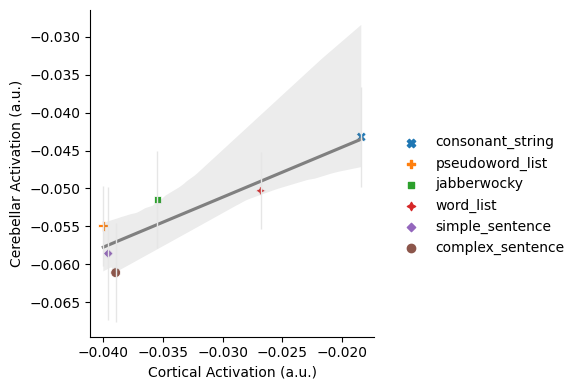

In [16]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [15]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  1.3125 5.0000 55.0000 0.2723



# ROI based analysis (WordRead-MDTB roi)

In [ ]:
df_path = os.path.join(gl.conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_WordRead.tsv")
df = pd.read_csv(df_path, sep="\t")

df_residuals = clean_dataframe(df)

agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)

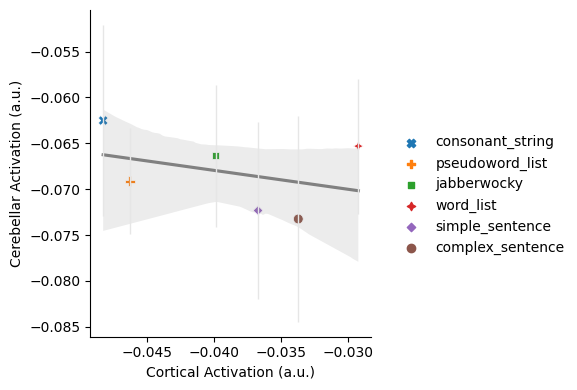

In [20]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [21]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  3.2922 5.0000 55.0000 0.0113



# ROI based analysis (VerbGen-MDTB roi)

In [22]:
df_path = os.path.join(gl.conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_VerbGen.tsv")
df = pd.read_csv(df_path, sep="\t")

df_residuals = clean_dataframe(df)

agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)


/tmp/ipykernel_9337/2372565576.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = dataframe.groupby(['sn', 'cond_name']).mean()
/tmp/ipykernel_9337/2372565576.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


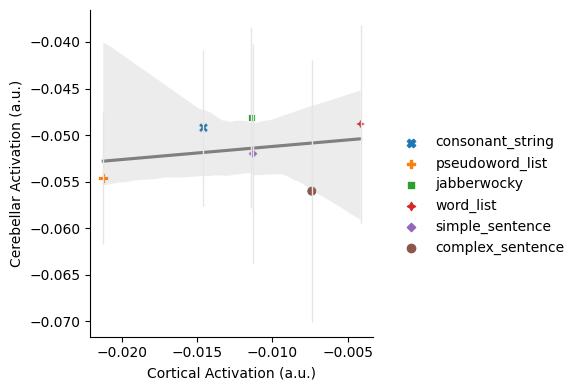

In [23]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [24]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.8327 5.0000 55.0000 0.5321



# ROI (Speech vs non_speech from IBC-archi)

In [25]:
df_path = os.path.join(gl.conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_speechvsnonspeech.tsv")
df = pd.read_csv(df_path, sep="\t")

df_residuals = clean_dataframe(df)

agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)

/tmp/ipykernel_9337/2372565576.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = dataframe.groupby(['sn', 'cond_name']).mean()
/tmp/ipykernel_9337/2372565576.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


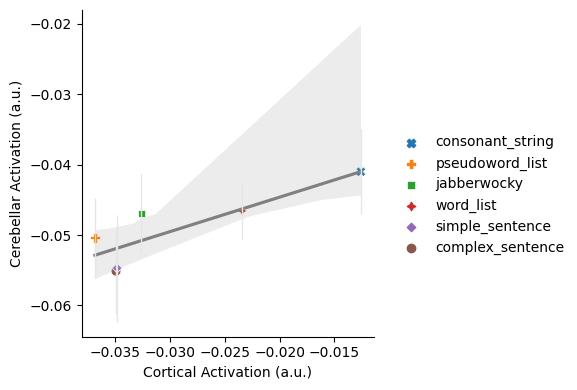

In [26]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [27]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  1.4782 5.0000 55.0000 0.2119



# CONNECTIVITY wordread MDTB-S1

In [30]:
# load the dataframe for the whole 
df_path = os.path.join(gl.conn_dir, "IBC", "sc_conn_MDTB_IBC_ses-rsvplanguage_WordRead.tsv")
df = pd.read_csv(df_path, sep="\t")

df_residuals = clean_dataframe(df)

agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)

/tmp/ipykernel_9337/2372565576.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = dataframe.groupby(['sn', 'cond_name']).mean()
/tmp/ipykernel_9337/2372565576.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


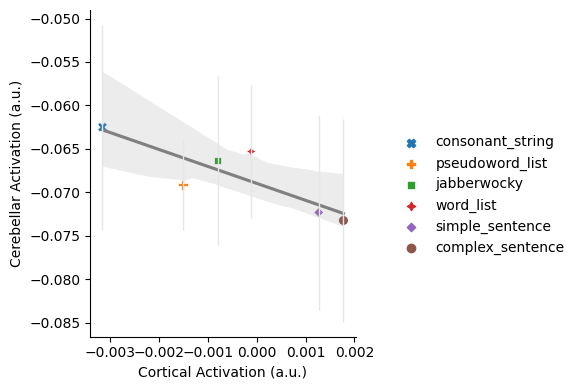

In [31]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [32]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  1.0208 5.0000 55.0000 0.4144



# Connectivity VerbGen MDTB-s1

In [33]:
# load the dataframe for the whole 
df_path = os.path.join(gl.conn_dir, "IBC", "sc_conn_MDTB_IBC_ses-rsvplanguage_VerbGen.tsv")
df = pd.read_csv(df_path, sep="\t")

df_residuals = clean_dataframe(df)

agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)


/tmp/ipykernel_9337/2372565576.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = dataframe.groupby(['sn', 'cond_name']).mean()
/tmp/ipykernel_9337/2372565576.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


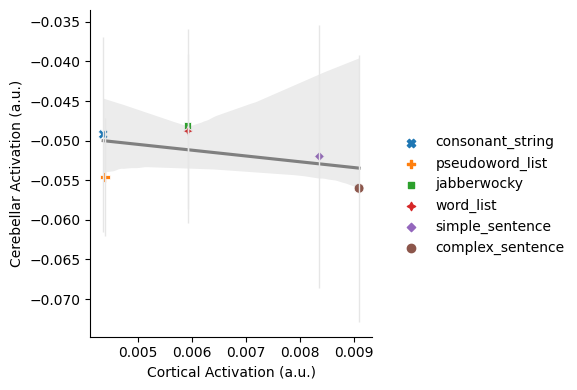

In [34]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [35]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  0.8936 5.0000 55.0000 0.4919



# Language ROI-nettekoven (S1-S4)

In [13]:
df= ra.get_summary(dataset='IBC', ses_id = 'ses-rsvplanguage',type = 'CondHalf',cerebellum_roi='tpl-SUIT/atl-language(S1-S4)_NettekovenSym68c32_space-SUIT', cortex_roi='tpl-fs32k/language(S1-S4)_NettekovenSym68c32.32k', add_rest = True)

df = df[df['cond_name'] != 'probe']
df = df.groupby(['sn', 'cond_name']).mean()
df = df.reset_index()

/tmp/ipykernel_165845/781632772.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['sn', 'cond_name']).mean()


In [14]:
df = ra.run_regress(df=df, fit_intercept= True)
df

,sn,cond_name,half,cond_num_uni,n_rep,Unnamed: 0,reg_id,cond_num,roi,X,Y,slope,intercept,R2,res
0,0.0,complex_sentence,1.5,190.0,1.0,31.5,1.0,NaN,0.0,-0.082107,-0.124759,1.363589,-0.006225,0.942036,-0.006573
1,0.0,consonant_string,1.5,191.0,1.0,32.5,2.0,NaN,0.0,-0.101008,-0.154194,1.363589,-0.006225,0.942036,-0.010235
2,0.0,jabberwocky,1.5,192.0,1.0,33.5,3.0,NaN,0.0,-0.114790,-0.151049,1.363589,-0.006225,0.942036,0.011702
3,0.0,pseudoword_list,1.5,194.0,1.0,35.5,5.0,NaN,0.0,-0.102795,-0.130715,1.363589,-0.006225,0.942036,0.015680
4,0.0,rest,NaN,NaN,NaN,NaN,8.0,8.0,0.0,0.000000,0.000000,1.363589,-0.006225,0.942036,0.006225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,11.0,jabberwocky,1.5,192.0,1.0,33.5,3.0,NaN,0.0,-0.001632,-0.098266,-0.879674,-0.077649,0.033372,-0.022053
80,11.0,pseudoword_list,1.5,194.0,1.0,35.5,5.0,NaN,0.0,0.009144,-0.089936,-0.879674,-0.077649,0.033372,-0.004243
81,11.0,rest,NaN,NaN,NaN,NaN,8.0,8.0,0.0,0.000000,0.000000,-0.879674,-0.077649,0.033372,0.077649
82,11.0,simple_sentence,1.5,195.0,1.0,36.5,6.0,NaN,0.0,0.004019,-0.094590,-0.879674,-0.077649,0.033372,-0.013407


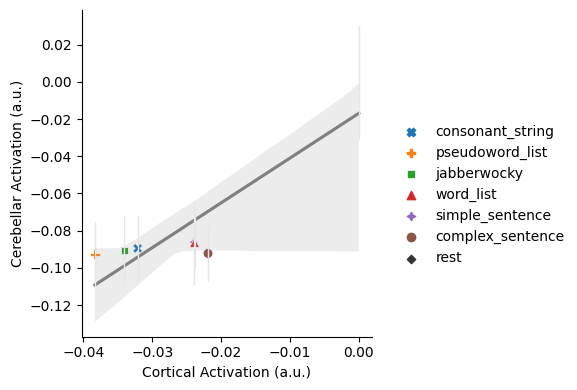

In [15]:
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df ,groupby = "cond_name", agg_kw=agg_kw)
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [16]:
print(AnovaRM(data=df, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  6.9851 6.0000 66.0000 0.0000



# MD ROI nettekoven (D1-D4)

In [11]:
df= ra.get_summary(dataset='IBC', ses_id = 'ses-rsvplanguage',type = 'CondHalf',cerebellum_roi='tpl-SUIT/atl-md(D1-D4)_NettekovenSym68c32_space-SUIT', cortex_roi='tpl-fs32k/md(D1-D4)_NettekovenSym68c32.32k', add_rest = True)

df = df[df['cond_name'] != 'probe']
df = df.groupby(['sn', 'cond_name']).mean()
df = df.reset_index()
df = ra.run_regress(df=df, fit_intercept= True)
display(df)

/tmp/ipykernel_165845/1193565044.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,half,cond_num_uni,n_rep,Unnamed: 0,reg_id,cond_num,roi,X,Y,slope,intercept,R2,res
0,0.0,complex_sentence,1.5,190.0,1.0,31.5,1.0,NaN,0.0,-0.118204,-0.072697,0.517184,-0.010879,0.885164,-0.000686
1,0.0,consonant_string,1.5,191.0,1.0,32.5,2.0,NaN,0.0,-0.008017,-0.029730,0.517184,-0.010879,0.885164,-0.014705
2,0.0,jabberwocky,1.5,192.0,1.0,33.5,3.0,NaN,0.0,-0.099404,-0.058120,0.517184,-0.010879,0.885164,0.004169
3,0.0,pseudoword_list,1.5,194.0,1.0,35.5,5.0,NaN,0.0,-0.087221,-0.050052,0.517184,-0.010879,0.885164,0.005937
4,0.0,rest,NaN,NaN,NaN,NaN,8.0,8.0,0.0,0.000000,0.000000,0.517184,-0.010879,0.885164,0.010879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,11.0,jabberwocky,1.5,192.0,1.0,33.5,3.0,NaN,0.0,0.048503,-0.043427,0.052163,-0.040686,0.004597,-0.005271
80,11.0,pseudoword_list,1.5,194.0,1.0,35.5,5.0,NaN,0.0,0.050075,-0.040437,0.052163,-0.040686,0.004597,-0.002363
81,11.0,rest,NaN,NaN,NaN,NaN,8.0,8.0,0.0,0.000000,0.000000,0.052163,-0.040686,0.004597,0.040686
82,11.0,simple_sentence,1.5,195.0,1.0,36.5,6.0,NaN,0.0,0.010231,-0.065460,0.052163,-0.040686,0.004597,-0.025308


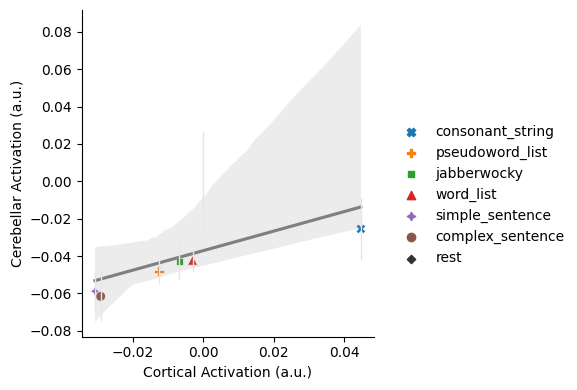

In [12]:
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df ,groupby = "cond_name", agg_kw=agg_kw)
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [7]:
print(AnovaRM(data=df, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cond_name  1.7162 5.0000 55.0000 0.1462

